<a href="https://colab.research.google.com/github/Singular-Brain/DeepBioLCNet/blob/main/BioLCNet_XOR_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [3]:
!pip install -q git+https://github.com/Singular-Brain/DeepBioLCNet

     |████████████████████████████████| 831.4 MB 2.8 kB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 120 kB 71.7 MB/s 
     |████████████████████████████████| 73 kB 2.3 MB/s 
     |████████████████████████████████| 280 kB 73.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# !wget https://data.deepai.org/mnist.zip
# !mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
# !unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

In [4]:
!git clone https://github.com/Singular-Brain/DeepBioLCNet
# import bindsent

Cloning into 'DeepBioLCNet'...
remote: Enumerating objects: 683, done.
remote: Counting objects: 100% (683/683), done.
remote: Compressing objects: 100% (549/549), done.
remote: Total 683 (delta 359), reused 359 (delta 117), pack-reused 0
Receiving objects: 100% (683/683), 35.46 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (359/359), done.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from torch.nn.modules.utils import _pair
from matplotlib.collections import PathCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Tuple, List, Optional, Sized, Dict, Union
import math
import random
# from ..utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights


In [6]:
from bindsnet.network.nodes import Nodes
import os
### import torch
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import collections
from torchvision import transforms
from torchvision import datasets
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch.nn.functional as fn

from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder, Encoder, NullEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes, IFNodes
from bindsnet.network.topology import Connection, MaxPool2dLocalConnection
from bindsnet.network.topology import LocalConnection, LocalConnectionOrig
from bindsnet.network.monitors import Monitor, AbstractMonitor, TensorBoardMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET, WeightDependentPostPre, Hebbian
from bindsnet.learning.reward import DynamicDopamineInjection, DopaminergicRPE
from bindsnet.analysis.plotting import plot_locally_connected_weights,plot_locally_connected_weights_meh,plot_spikes,\
plot_LC_timepoint_spikes,plot_locally_connected_weights_meh2,plot_convergence_and_histogram,plot_locally_connected_weights_meh3
from bindsnet.analysis.visualization import plot_weights_movie, plot_spike_trains_for_example,summary, plot_voltage
from bindsnet.utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights

## Sets up Gpu use and manual seed


In [7]:
if torch.cuda.is_available():
    device =  torch.device("cuda")
    gpu = True
else:
    device =  torch.device("cpu")
    gpu = False

def manual_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 2045 # The Singularity is Near!
manual_seed(SEED)
WANDB = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)


Running on Device =  cuda


# Custom Monitors

## Reward Monitor

In [8]:
class RewardMonitor(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        time: None,
        batch_size: int = 1,
        device: str = "cpu",
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()

        self.time = time
        self.batch_size = batch_size
        self.device = device

        # if time is not specified the monitor variable accumulate the logs
        if self.time is None:
            self.device = "cpu"

        self.recording = []
        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if "reward" in kwargs:
            self.recording.append(kwargs["reward"])
        # remove the oldest element (first in the list)
        # if self.time is not None:
        #     self.recording.pop(0)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = []


## Plot Eligibility trace

In [9]:
class PlotET(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        i,
        j,
        source,
        target,
        connection,
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()
        self.i = i
        self.j = j
        self.source = source
        self.target = target
        self.connection = connection

        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if hasattr(self.connection.update_rule, 'p_plus'):
            self.recording['spikes_i'].append(self.source.s.ravel()[self.i].item())
            self.recording['spikes_j'].append(self.target.s.ravel()[self.j].item())
            self.recording['p_plus'].append(self.connection.update_rule.p_plus[self.i].item())
            self.recording['p_minus'].append(self.connection.update_rule.p_minus[self.j].item())
            self.recording['eligibility'].append(self.connection.update_rule.eligibility[self.i,self.j].item())
            self.recording['eligibility_trace'].append(self.connection.update_rule.eligibility_trace[self.i,self.j].item())
            self.recording['w'].append(self.connection.w[self.i,self.j].item())

    def plot(self):

        fig, axs  = plt.subplots(7)
        fig.set_size_inches(10, 20)
        for i, (name, p) in enumerate(self.recording.items()):
            axs[i].plot(p[-250:])
            axs[i].set_title(name)
    
        fig.show()

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = {
        'spikes_i': [],
        'spikes_j': [],
        'p_plus':[],
        'p_minus':[],
        'eligibility':[],
        'eligibility_trace':[],
        'w': [],
        }


## Kernel 

In [10]:
class AbstractKernel(ABC):
    def __init__(self, kernel_size):
        """
        Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
        Instantiates a ``Filter Kernel`` object.
        :param window_size : The size of the kernel (int)
        """
        self.window_size = kernel_size

    def __call__(self):
        pass


In [11]:
class DoGKernel(AbstractKernel):
    def __init__(self, kernel_size: Union[int, Tuple[int, int]], sigma1 : float, sigma2 : float):
        """
        Generates DoG filter kernels.
        :param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
        :param sigma1 : The sigma parameter for the first Gaussian function.
        :param sigma2 : The sigma parameter for the second Gaussian function.
        """
        super(DoGKernel, self).__init__(kernel_size)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
    def __call__(self):
        k = self.window_size//2
        x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
        a = 1.0 / (2 * math.pi)
        prod = x*x + y*y
        f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
        f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
        dog = a * (f1-f2)
        dog_mean = np.mean(dog)
        dog = dog - dog_mean
        dog_max = np.max(dog)
        dog = dog / dog_max
        dog_tensor = torch.from_numpy(dog)
        # returns a 2d tensor corresponding to the requested DoG filter
        return dog_tensor.float()

In [12]:
class Filter():
    """
    Applies a filter transform. Each filter contains a sequence of :attr:`FilterKernel` objects.
    The result of each filter kernel will be passed through a given threshold (if not :attr:`None`).
    Args:
        filter_kernels (sequence of FilterKernels): The sequence of filter kernels.
        padding (int, optional): The size of the padding for the convolution of filter kernels. Default: 0
        thresholds (sequence of floats, optional): The threshold for each filter kernel. Default: None
        use_abs (boolean, optional): To compute the absolute value of the outputs or not. Default: False
    .. note::
        The size of the compund filter kernel tensor (stack of individual filter kernels) will be equal to the 
        greatest window size among kernels. All other smaller kernels will be zero-padded with an appropriate 
        amount.
    """
    # filter_kernels must be a list of filter kernels
    # thresholds must be a list of thresholds for each kernel
    def __init__(self, filter_kernels, padding=0, thresholds=None, use_abs=False):
        tensor_list = []
        self.max_window_size = 0
        for kernel in filter_kernels:
            if isinstance(kernel, torch.Tensor):
                tensor_list.append(kernel)
                self.max_window_size = max(self.max_window_size, kernel.size(-1))
            else:
                tensor_list.append(kernel().unsqueeze(0))
                self.max_window_size = max(self.max_window_size, kernel.window_size)
        for i in range(len(tensor_list)):
            p = (self.max_window_size - filter_kernels[i].window_size)//2
            tensor_list[i] = fn.pad(tensor_list[i], (p,p,p,p))

        self.kernels = torch.stack(tensor_list)
        self.number_of_kernels = len(filter_kernels)
        self.padding = padding
        if isinstance(thresholds, list):
            self.thresholds = thresholds.clone().detach()
            self.thresholds.unsqueeze_(0).unsqueeze_(2).unsqueeze_(3)
        else:
            self.thresholds = thresholds
        self.use_abs = use_abs

    # returns a 4d tensor containing the flitered versions of the input image
    # input is a 4d tensor. dim: (minibatch=1, filter_kernels, height, width)
    def __call__(self, input):

        # if input.dim() == 3:
        #     input2 = torch.unsqueeze(input, 0)
        input.unsqueeze_(0)
        output = fn.conv2d(input, self.kernels, padding = self.padding).float()
        if not(self.thresholds is None):
            output = torch.where(output < self.thresholds, torch.tensor(0.0, device=output.device), output)
        if self.use_abs:
            torch.abs_(output)
        return output.squeeze(0)

# Design network

In [13]:
WANDB = True
if WANDB:
    !pip install -q wandb
    !wandb login
    import wandb

     |████████████████████████████████| 1.7 MB 31.5 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 142 kB 51.0 MB/s 
     |████████████████████████████████| 180 kB 22.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1
def convergence(c):
    if c.norm is None:
        return 1-torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2
    else:
        mean_norm_factor = c.norm / c.w.shape[-1]
        return  1-(torch.mean((c.w-c.wmin)*(c.wmax-c.w))/((c.wmax-c.wmin)/2)**2)

        
class LCNet(Network):
    def __init__(
        self,
        n_classes: int,
        neuron_per_class: int,
        in_channels : int,
        n_channels1: int,
        n_channels2: int,
        filter_size1: int,
        filter_size2: int,
        stride1: int,
        stride2: int,
        maxPool1: bool,
        maxPool2: bool,
        online: bool,
        deep: bool,
        time: int,
        reward_fn,
        n_neurons: int,
        pre_observation: bool,
        has_decision_period: bool,
        local_rewarding: bool,
        nu_LC: Union[float, Tuple[float, float]],
        nu_LC2: Union[float, Tuple[float, float]],
        nu_Output: float,
        dt: float,
        crop_size:int ,
        nu_inh_LC: float,
        nu_inh: float,
        inh_type,
        inh_LC: bool,
        inh_LC2: bool,
        inh_factor_LC: float,
        inh_factor_LC2: float,
        inh_factor:float,
        single_output_layer:bool,
        NodesType_LC,
        NodesType_Output, 
        update_rule_LC,
        update_rule_LC2,
        update_rule_Output,
        update_rule_inh,
        update_rule_inh_LC,
        wmin: float,
        wmax: float ,
        soft_bound,
        theta_plus: float,
        tc_theta_decay: float,
        tc_trace:int,
        normal_init:bool,
        mu: float,
        std:float,
        norm_factor_inh_LC: bool,
        norm_factor_LC,
        norm_factor_LC2,
        norm_factor_out,
        norm_factor_inh,
        trace_additive,
        load_path,
        save_path,
        LC_weights_path,
        LC2_weights_path,
        confusion_matrix,
        lc_weights_vis,
        out_weights_vis,
        lc_convergence_vis,
        out_convergence_vis,
        thresh_LC,
        thresh_FC,
        wandb_active = False,
        batch_size=1,
        epocsh=1,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``BioLCNet``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``(adaptive)LIFNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``(adaptive)LIFNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=online)
        kwargs['single_output_layer'] = single_output_layer
        kwargs['dt'] = dt
        kwargs['n_labels'] = n_classes
        kwargs['neuron_per_class'] = neuron_per_class
        
        self.dt = dt
        self.reward_fn = reward_fn(**kwargs)
        self.batch_size = batch_size
        self.reward_fn.network = self
        self.reward_fn.dt = self.dt
        self.n_classes = n_classes
        self.neuron_per_class = neuron_per_class
        self.save_path = save_path
        self.load_path = load_path
        self.deep = deep
        self.maxPool1 = maxPool1
        self.maxPool2 = maxPool2
        self.time = time
        self.crop_size = crop_size
        self.filter_size1 = filter_size1
        self.filter_size2 = filter_size2
        self.clamp_intensity = kwargs.get('clamp_intensity',None)
        self.single_output_layer = single_output_layer
        self.pre_observation = pre_observation
        self.has_decision_period = has_decision_period
        self.local_rewarding = local_rewarding
        self.soft_bound = soft_bound
        self.confusion_matrix = confusion_matrix
        self.lc_weights_vis = lc_weights_vis
        self.out_weights_vis = out_weights_vis
        self.lc_convergence_vis = lc_convergence_vis
        self.out_convergence_vis = out_convergence_vis
        self.in_channels = in_channels
        self.n_channels1 = n_channels1
        self.n_channels2 = n_channels2
        self.convergences = {}
        self.norm_factor_LC = norm_factor_LC
        self.norm_factor_LC2 = norm_factor_LC2
        self.norm_factor_out = norm_factor_out
        self.wmin = wmin 
        self.wmax = wmax
        self.wandb_active = wandb_active
        self.epochs_trained = 0
        self.epochs = epochs

        self.time_analysis = kwargs.get('time_analysis', False)
        print(self.time_analysis)
        if kwargs['variant'] == 'scalar':
            assert self.has_decision_period == True, ''

        if self.online == False:
            assert self.has_decision_period == True, ''
        
        if self.has_decision_period == True:
            assert self.online == False, "Decision period is not compatible with online learning."
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.decision_period = kwargs['decision_period']
            assert self.decision_period > 0, ""
            self.learning_period = self.time - self.observation_period - self.decision_period

        elif self.pre_observation == True:
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.learning_period = self.time - self.observation_period
            self.decision_period = self.time - self.observation_period

        else:
            self.observation_period = 0
            self.decision_period = self.time
            self.learning_period = self.time

        ### nodes
        inp = Input(shape= [in_channels,crop_size,crop_size], traces=True, tc_trace=tc_trace,traces_additive = trace_additive)
        self.add_layer(inp, name="input")

        ## First hidden layer
        conv_size1 = compute_size(crop_size, filter_size1, stride1)
        main1 = NodesType_LC(shape= [n_channels1, conv_size1, conv_size1], thresh = thresh_LC, traces=True, tc_trace=tc_trace,
                             traces_additive = trace_additive,tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
        
        self.add_layer(main1, name="main1")

        ### connections 
        LC1 = LocalConnectionOrig(inp, main1, filter_size1, stride1, n_channels1,\
                              nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, norm = norm_factor_LC)

        # LC1 = LocalConnection(inp, main1, filter_size1, stride1, in_channels, n_channels1,input_shape=(crop_size,crop_size),\
        #                      nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC)


        if LC_weights_path:
            a = torch.load(LC_weights_path)
            LC1.w.data = a['state_dict']['input_to_main1.w']
            print("Weights loaded ...")
        
        elif normal_init:
            w_lc_init = torch.normal(mu,std, size = (in_channels, n_channels1 * compute_size(crop_size, filter_size1, stride1)**2, filter_size1**2))
            LC1.w.data = w_lc_init
       
        self.add_connection(LC1, "input", "main1")
        self.convergences['lc1'] = []

        if inh_LC:
            main_width = compute_size(crop_size, filter_size1, stride1)
            w_inh_LC = torch.zeros(n_channels1,main_width,main_width,n_channels1,main_width,main_width)
            for c in range(n_channels1):
                for w1 in range(main_width):
                    for w2 in range(main_width):
                        w_inh_LC[c,w1,w2,:,w1,w2] = - inh_factor_LC
                        w_inh_LC[c,w1,w2,c,w1,w2] = 0
        
            w_inh_LC = w_inh_LC.reshape(main1.n,main1.n)
                                                             
            LC_recurrent_inhibition = Connection(
                source=main1,
                target=main1,
                w=w_inh_LC,
            )
            self.add_connection(LC_recurrent_inhibition, "main1", "main1")
        
        
        self.final_connection_source_name = 'main1'
        self.final_connection_source = main1

        self.hidden2 = main1
        self.hidden2_name = 'main1'
        if maxPool1:
            maxPool_kernel = 2
            maxPool_stride = 2
            
            conv_size1 =compute_size(conv_size1, maxPool_kernel, maxPool_stride)
            self.final_connection_source_name = 'maxpool1'
            
            maxpool1 = LIFNodes(shape= [self.n_channels1, conv_size1, conv_size1], refrac = 0)
            self.add_layer(maxpool1, name="maxpool1")
            self.final_connection_source = maxpool1
            
            maxPoolConnection = MaxPool2dLocalConnection(main1, maxpool1, maxPool_kernel, maxPool_stride)
            self.add_connection(maxPoolConnection, "main1", 'maxpool1')
            
            self.hidden2 = maxpool1
            self.hidden2_name = 'maxpool1'

        if deep:
            # # Second hidden layer
            conv_size2 = compute_size(conv_size1, filter_size2, stride2)

            main2 = NodesType_LC(shape= [n_channels2, conv_size2, conv_size2],traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                                            tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
            
            self.add_layer(main2, name="main2")

            ### connections 
            lc2_input_shape = (conv_size1,conv_size1)
            LC2 = LocalConnection(self.hidden2, main2, filter_size2, stride2, n_channels1, n_channels2, input_shape= lc2_input_shape,
            nu = _pair(nu_LC2), update_rule = update_rule_LC2, wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC2)

            self.add_connection(LC2,  self.hidden2_name, "main2")
            self.convergences['lc2'] = []
            if LC2_weights_path:
                a = torch.load(LC2_weights_path)
                LC2.w.data = a['state_dict']['main1_to_main2.w']
                print("Weights loaded ...")
            
            elif normal_init:
                w_lc_init = torch.normal(mu,std, size = (n_channels1, n_channels2 * compute_size(conv_size1, filter_size2, stride2)**2, filter_size2**2))
                LC2.w.data = w_lc_init

            self.final_connection_source_name = 'main2'
            self.final_connection_source = main2

            if inh_LC2:
                main_width = conv_size2
                w_inh_LC2 = torch.zeros(n_channels2,main_width,main_width,n_channels2,main_width,main_width)
                for c in range(n_channels2):
                    for w1 in range(main_width):
                        for w2 in range(main_width):
                            w_inh_LC2[c,w1,w2,:,w1,w2] = - inh_factor_LC2
                            w_inh_LC2[c,w1,w2,c,w1,w2] = 0
            
                w_inh_LC2 = w_inh_LC2.reshape(main2.n,main2.n)
                                                                
                LC_recurrent_inhibition2 = Connection(
                    source=main2,
                    target=main2,
                    w=w_inh_LC2,
                )
                self.add_connection(LC_recurrent_inhibition2, "main2", "main2")


            if maxPool2:
                maxPool_kernel = 2
                maxPool_stride = 2
                conv_size2 =compute_size(conv_size2, maxPool_kernel, maxPool_stride)
                self.final_connection_source_name = 'maxpool2'
                maxpool2 = LIFNodes(shape= [self.n_channels2, conv_size2, conv_size2], refrac = 0)
                self.final_connection_source = maxpool2
                maxPoolConnection2 = MaxPool2dLocalConnection(main2, maxpool2, maxPool_kernel, maxPool_stride)

                self.add_layer(maxpool2, name="maxpool2")
                self.add_connection(maxPoolConnection2, "main2", 'maxpool2')


        ### main2 to output
        out = NodesType_Output(n= n_neurons, traces=True,traces_additive = trace_additive, thresh=thresh_FC, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)

        self.add_layer(out, "output")

        last_main_out = Connection(self.final_connection_source, out, nu = nu_Output, update_rule = update_rule_Output, wmin = wmin, wmax= wmax, norm = norm_factor_out)

        if normal_init:
            w_last_main_init = torch.normal(mu,std,size = (self.final_connection_source.n,out.n)) 
            last_main_out.w.data = w_last_main_init
        print(torch.mean(last_main_out.w),torch.std(last_main_out.w))    
        self.add_connection(last_main_out, self.final_connection_source_name, "output")
        self.convergences['last_main_out'] = []
        ### Inhibitory:
        if inh_type == 'between_layers':
            w = -inh_factor * torch.ones(out.n, out.n)
            for c in range(n_classes):
                ind = slice(c*neuron_per_class,(c+1)*neuron_per_class)
                w[ind, ind] = 0

            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        elif inh_type == 'one_2_all':
            w = -inh_factor * (torch.ones(out.n, out.n) - torch.eye(out.n, out.n))
            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        # Diehl and Cook
        elif inh_type == 'DC':
            raise NotImplementedError('Diehl and cook not implemented yet fo r 10 classes')

        # Directs network to GPU
        if gpu:
            self.to("cuda")


    def fit(
        self,
        dataloader,
        val_loader,
        reward_hparams,
        label = None,
        hparams = None,
        online_validate = True,
        n_train = 2000,
        n_test = 250,
        n_val = 250,
        val_interval = 250,
        running_window_length = 250,
        verbose = True,
    ):
        manual_seed(SEED)
        if self.wandb_active:
            wandb.watch(self)
        self.verbose = verbose
        self.label = label
        # add Monitors
        #main_monitor = Monitor(self.layers["main"], ["v"], time=None, device=device)
        reward_monitor = RewardMonitor(time =self.time)
        #Plot_et = PlotET(i = 0, j = 0, source = self.layers["main"], target = self.layers["output"], connection = self.connections[("main","output")])
        #tensorboard = TensorBoardMonitor(self, time = self.time)
        #self.add_monitor(main_monitor, name="main")
        self.add_monitor(reward_monitor, name="reward")
        #self.add_monitor(Plot_et, name="Plot_et")
        #self.add_monitor(tensorboard, name="tensorboard")

            
        acc_hist = collections.deque([], running_window_length)

        #if self.single_output_layer:
        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)
            self.dopaminergic_layers = self.layers["output"]
        # else:
        #     output_layers = set([layer for layer in self.layers if layer.startswith('output')])
        #     self.output_spikes = {}
        #     for layer in output_layers:
        #         self.output_spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=self.time)
        #         self.add_monitor(self.output_spikes[layer], name="%s_spikes" % layer)
        #         self.dopaminergic_layers = {name: layer for name, layer in self.layers.items() if name.startswith('output')}

        val_acc = 0.0
        acc = 0.0

        reward_history = []
        if self.load_path:
            # try:
            self.model_params = torch.load(self.load_path)
            self.load_state_dict(torch.load(self.load_path)['state_dict'])
            iteration =  self.model_params['iteration']
            hparams = self.model_params['hparams']
            train_accs = self.model_params['train_accs']
            val_accs = self.model_params['val_accs']
            acc_rewards = self.model_params['acc_rewards']
            print(f'Previous model loaded! Resuming training from iteration {iteration}..., last running training accuracy: {train_accs[-1]}, last validation accuracy: {val_accs[-1]}\n') if self.verbose else None
        else:
            print(f'Previous model not found! Training from the beginning...\n') if self.verbose else None
            val_accs = []
            train_accs = []
            acc_rewards = []
            # except:
            #     pass
        pbar = tqdm(total=n_train)
        self.reset_state_variables()
        
        if self.time_analysis:
            self.sample_spikes = {'input': [], 'main1': [], 'output': []}

        for epoch in range(self.epochs):
            for (i, data) in enumerate(dataloader):
                if self.load_path:
                    #try:
                    if i*self.batch_size <= iteration:
                        n_train += self.batch_size
                        continue
                    # except:
                    #     pass
                if i*self.batch_size > n_train:
                    break

                image = data["encoded_image"]
                if self.label is None : label = data["label"]

                # Run the network on the input.
                if gpu:
                    inputs = {"input": torch.transpose(image.cuda(),0,1)}
                else:
                    inputs = {"input": torch.transpose(image,0,1)}
                #print(self.spikes['output'].get('s'))

                ### Spike clamping (baseline activity)

                clamp = {}
                if self.clamp_intensity is not None:
                    encoder = PoissonEncoder(time = self.time, dt = self.dt)
                    clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

                self.run(inputs=inputs, 
                        time=self.time, 
                        **reward_hparams,
                        one_step=True,
                        true_label = label,
                        dopaminergic_layers= self.dopaminergic_layers,
                        clamp = clamp
                        )

                # Get voltage recording.
                #main_voltage = main_monitor.get("v")
                reward =reward_monitor.get()
                reward_history.append(reward)
                #tensorboard.update(step= i)

                # Add to spikes recording.
                #if self.single_output_layer:
                lc_spikes1 = self.spikes['main1'].get('s')
                #lc_spikes2 = self.spikes['main2'].get('s')
                out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
                sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
                predicted_label = torch.argmax(sum_spikes, dim=1)
                

                if self.time_analysis:
                    self.sample_spikes['input'].append(self.spikes['input'].get('s'))
                    self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
                    self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size,n_classes, neuron_per_class))

                # else:
                #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
                #     for c in range(self.n_classes):
                #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
                #     sum_spikes = spikes_record.sum(1).sum(1)
                #     predicted_label = torch.argmax(sum_spikes)    

                acc_hist.append((predicted_label == label).sum())
    
                w_lc1 = self.connections[('input', 'main1')].w
                w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
                #w_lc2 = self.connections[('main1', 'main2')].w
                #w_inh = self.connections[('output','output')].w
                convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
                convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
                if self.norm_factor_LC is not None:
                    mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
                    convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
                if self.norm_factor_out is not None:    
                    mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
                    convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
            
                self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
                self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 
                #print(sum_spikes.shape)
                # print("output", sum_spikes, 'pred_label:',
                #     predicted_label, 'GT:', label,
                #     ', Acc Rew:', sum(reward_monitor.get()),
                #     f"Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}",
                #     f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f},main_mean_fire_freq:{torch.mean(lc_spikes1.float())*1000:.1f}",#" main2_mean_fire_freq:{torch.mean(lc_spikes2.float())*1000:.1f}",
                #     f"output_mean_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}",
                #     f"mean_lc1_w: {torch.mean(w_lc1):.5f}, mean_fc_w:{torch.mean(w_last_main_out):.5f}",
                #     f"std_lc1_w: {torch.std(w_lc1):.5f}, std_fc_w:{torch.std(w_last_main_out):.5f}",
                #     f"convergence_lc1: {convg_lc1:.5f}, convergence_fc: {convg_out:.5f}",)
                    #end = '')           
                
                acc = 100 * sum(acc_hist)/(len(acc_hist)*self.batch_size)
                if self.wandb_active:
                    wandb.log({
                            **{' to '.join(name) + ' convergence': convergence(c).item() for name, c in self.connections.items() if name[0]!=name[1]},
                            **{'training accuracy': acc},
                            **{"Reward": sum(sum(reward))},
                            **{' to '.join(name) + ' std': c.w.std().item() for name, c in self.connections.items() if name[0]!=name[1]},
                            **{name + ' spikes': monitor.get('s').sum().item() for name, monitor in self.spikes.items()},
                            **{' to '.join(name) + " gradients": wandb.Histogram(c.w.cpu()) for name, c in self.connections.items() if name[0]!=name[1]},
                        },
                        step = self.epochs_trained)


                
                self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 

                if online_validate and i % val_interval == 0 and i!=0:
                    self.reset_state_variables()
                    val_acc = self.evaluate(val_loader, n_val, val_interval, running_window_length)
                    #tensorboard.writer.add_scalars("accuracy", {"train": acc, "val" : val_acc}, i)
                    train_accs.append(acc)
                    val_accs.append(val_acc)
                    #acc_rewards.append(sum(reward_monitor.get()))
                    if self.save_path is not None:
                        model_params = {'state_dict': self.state_dict(), 'hparams': hparams, 'iteration': i, 'val_accs': val_accs, 'train_accs': train_accs, 'acc_rewards': acc_rewards}
                        torch.save(model_params, self.save_path)
                # else:
                #     pass
                    #tensorboard.writer.add_scalars("accuracy", {"train": acc}, i)
                #tensorboard.writer.add_scalar("reward", sum(reward_monitor.get()), i)

                # if  i % val_interval == 0 and i!=0:
                #     fig = create_plot(self.output_spikes, reward_monitor.get(), label)
                #     tensorboard.writer.add_figure('reward', fig, i)
                
                #Plot_et.plot()    
                self.reset_state_variables()  # Reset state variables.
                
                pbar.set_description_str("Epoch: "+str(epoch)+", Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
                pbar.update(len(label))

                self.epochs_trained += 1

        result_metrics = {'train_acc': acc, 'val_acc': val_acc}
        # tensorboard.writer.add_hparams(
        #     {k:(v if type(v) in (int, float, bool, str, torch.Tensor) else str(v)) for k,v in {**train_hparams, **data_hparams, **network_hparams, **reward_hparams}.items() },
        #     result_metrics
        # )
    
    def predict(self, dataloader, idx,  reward_hparams, label = None):
        reward_monitor = RewardMonitor(time =self.time)

        for i, data in enumerate(dataloader):
            if i*self.batch_size == idx:
                image = data["encoded_image"]
                if self.label is None : label = data["label"]

        # Run the network on the input.
        if gpu:
            inputs = {"input": torch.transpose(image.cuda(),0,1)}
        else:
            inputs = {"input": torch.transpose(image,0,1)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step=True,
                true_label = label,
                dopaminergic_layers= self.dopaminergic_layers,
                clamp = clamp
                    )
        
        out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
        sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
        predicted_label = torch.argmax(sum_spikes, dim=1)

        if self.time_analysis:
            self.sample_spikes['input'].append(self.spikes['input'].get('s'))
            self.sample_spikes['main1'].append(self.spikes['main1'].get('s'))
            self.sample_spikes['output'].append(self.spikes['output'].get('s').view(self.time, self.batch_size, n_classes, neuron_per_class))

        w_lc1 = self.connections[('input', 'main1')].w
        w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
        #w_lc2 = self.connections[('main1', 'main2')].w
        #w_inh = self.connections[('output','output')].w
        convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
        convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
        if self.norm_factor_LC is not None:
            mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
            convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
        if self.norm_factor_out is not None:    
            mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
            convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
        
        self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
        self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 
    
        # print("\routput", sum_spikes, 'pred_label:',
        #     predicted_label, 'GT:', label,
        #     ', Acc Rew:', round(sum(reward_monitor.get()).item(),4),
        #     f"Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}",
        #     f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f},main_mean_fire_freq:{torch.mean(lc_spikes1.float())*1000:.1f}",#" main2_mean_fire_freq:{torch.mean(lc_spikes2.float())*1000:.1f}",
        #     f"output_mean_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}",
        #     f"mean_lc1_w: {torch.mean(w_lc1):.5f}, mean_fc_w:{torch.mean(w_last_main_out):.5f}",
        #     f"std_lc1_w: {torch.std(w_lc1):.5f}, std_fc_w:{torch.std(w_last_main_out):.5f}",
        #     f"convergence_lc1: {convg_lc1:.5f}, convergence_fc: {convg_out:.5f}",
        #     end = '')           
        
        acc = 100 * sum(acc_hist)/(len(acc_hist)*self.batch_size)
        
        self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 
        
        self.reset_state_variables()  # Reset state variables.

        return label, predicted_label, reward_monitor.get() 

    def evaluate(self, val_loader, n_val, val_interval, running_window_length):
        manual_seed(SEED)
        acc_hist_val = collections.deque([], running_window_length)

        spikes_val = {}

        self.train(False)
        self.learning = False

        GT, y_pred = [], []
        for (i, data) in enumerate(val_loader):
            if i*self.batch_size > n_val:
                break

            image = data["encoded_image"]
            if self.label is None : 
              label = data["label"]
            else :
              label = self.label

            # Run the network on the input.
            if gpu:
                inputs = {"input": torch.transpose(image.cuda(),0,1)}
            else:
                inputs = {"input": torch.transpose(image,0,1)}

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    one_step = True,
                    true_label = label,
                    dopaminergic_layers= self.dopaminergic_layers,
                     )
            # Add to spikes recording.
            #if self.single_output_layer:
            out_spikes = self.spikes["output"].get("s").view(self.time, self.batch_size, n_classes, neuron_per_class)
            sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(2)
            predicted_label = torch.argmax(sum_spikes, dim=1)
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)

            acc_hist_val.append((predicted_label == label).sum())
            
            GT.append(label)
            y_pred.append(predicted_label)
            
            # print("\r*validation: output",sum_spikes,
            #     'predicted_label:', predicted_label, 'GT:', label,
            #     end = '') if self.verbose else None
            
            self.reset_state_variables()  # Reset state variables.

        self.train(True)
        self.learning = True
        
        if self.confusion_matrix:
            self.plot_confusion_matrix(GT, y_pred)

        if self.lc_weights_vis:
            plot_locally_connected_weights_meh(self.connections[('input','main1')].w,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])
            plt.show()
            if self.deep:
                plot_locally_connected_weights_meh(self.connections[(self.hidden2_name,'main1')].w,self.n_channels2,self.n_channels1,0,self.layers[self.hidden2_name].shape[1],self.filter_size2,self.layers['main2'].shape[1])                
                plt.show()
        
        if self.lc_convergence_vis: 
            plot_convergence_and_histogram(self.connections[('input','main1')].w,self.convergences['lc1'])
            plt.show()
        if self.out_convergence_vis:
            plot_convergence_and_histogram(self.connections[(self.final_connection_source_name,'output')].w,self.convergences['last_main_out'])
            plt.show() 

        if self.out_weights_vis:
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,0,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1]) 
            plt.show()
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,1,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])           
            plt.show()
        val_acc = 100 * sum(acc_hist_val)/(len(acc_hist_val)*self.batch_size)
        return val_acc

    @staticmethod
    def plot_confusion_matrix(GT, y_predicted):
        cm = confusion_matrix(GT, y_predicted)
        plt.figure(figsize = (10,7))
        sn.heatmap(cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

    
    def one_step(self,datum,label = None):
        self.reset_state_variables()
        
        image = datum["encoded_image"]
        if label is None : label = datum["label"]

        if gpu:
            inputs = {"input": torch.transpose(image.cuda(),0,1)}
        else:
            inputs = {"input": torch.transpose(image,0,1)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step = True,
                true_label = label,
                dopaminergic_layers= self.dopaminergic_layers,
                )
    

# Load Dataset

In [15]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source, mask = None):
        if mask is not None:
            self.mask = mask
        else:
            raise ValueError()
            self.mask = torch.tensor([1 if data_source[i]['label'] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# !cp /content/drive/MyDrive/train-20220122T160532Z-001.zip ./
# !cp /content/drive/MyDrive/test-20220122T154947Z-001.zip ./ 

# !unzip /content/test-20220122T154947Z-001.zip -d ./test
# !unzip /content/train-20220122T160532Z-001.zip -d ./train 

In [18]:
import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from typing import Union

from PIL import Image

from torchvision.datasets import VisionDataset


def has_file_allowed_extension(filename: str, extensions: Union[str, Tuple[str, ...]]) -> bool:
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions if isinstance(extensions, str) else tuple(extensions))


def is_image_file(filename: str) -> bool:
    """Checks if a file is an allowed image extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.

    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


def make_dataset(
    directory: str,
    class_to_idx: Optional[Dict[str, int]] = None,
    extensions: Optional[Union[str, Tuple[str, ...]]] = None,
    is_valid_file: Optional[Callable[[str], bool]] = None,
) -> List[Tuple[str, int]]:
    """Generates a list of samples of a form (path_to_sample, class).

    See :class:`DatasetFolder` for details.

    Note: The class_to_idx parameter is here optional and will use the logic of the ``find_classes`` function
    by default.
    """
    directory = os.path.expanduser(directory)

    if class_to_idx is None:
        _, class_to_idx = find_classes(directory)
    elif not class_to_idx:
        raise ValueError("'class_to_index' must have at least one entry to collect any samples.")

    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")

    if extensions is not None:

        def is_valid_file(x: str) -> bool:
            return has_file_allowed_extension(x, extensions)  # type: ignore[arg-type]

    is_valid_file = cast(Callable[[str], bool], is_valid_file)

    instances = []
    available_classes = set()
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)

                    if target_class not in available_classes:
                        available_classes.add(target_class)

    empty_classes = set(class_to_idx.keys()) - available_classes
    if empty_classes:
        msg = f"Found no valid file for the classes {', '.join(sorted(empty_classes))}. "
        if extensions is not None:
            msg += f"Supported extensions are: {extensions if isinstance(extensions, str) else ', '.join(extensions)}"
        raise FileNotFoundError(msg)

    return instances


class DatasetFolder(VisionDataset):
    """A generic data loader.

    This default directory structure can be customized by overriding the
    :meth:`find_classes` method.

    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (tuple[string]): A list of allowed extensions.
            both extensions and is_valid_file should not be passed.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
        is_valid_file (callable, optional): A function that takes path of a file
            and check if the file is a valid file (used to check of corrupt files)
            both extensions and is_valid_file should not be passed.

     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
        targets (list): The class_index value for each image in the dataset
    """

    def __init__(
        self,
        root: str,
        loader: Callable[[str], Any],
        extensions: Optional[Tuple[str, ...]] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        classes, class_to_idx = self.find_classes(self.root)
        samples = self.make_dataset(self.root, class_to_idx, extensions, is_valid_file)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    @staticmethod
    def make_dataset(
        directory: str,
        class_to_idx: Dict[str, int],
        extensions: Optional[Tuple[str, ...]] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> List[Tuple[str, int]]:
        """Generates a list of samples of a form (path_to_sample, class).

        This can be overridden to e.g. read files from a compressed zip file instead of from the disk.

        Args:
            directory (str): root dataset directory, corresponding to ``self.root``.
            class_to_idx (Dict[str, int]): Dictionary mapping class name to class index.
            extensions (optional): A list of allowed extensions.
                Either extensions or is_valid_file should be passed. Defaults to None.
            is_valid_file (optional): A function that takes path of a file
                and checks if the file is a valid file
                (used to check of corrupt files) both extensions and
                is_valid_file should not be passed. Defaults to None.

        Raises:
            ValueError: In case ``class_to_idx`` is empty.
            ValueError: In case ``extensions`` and ``is_valid_file`` are None or both are not None.
            FileNotFoundError: In case no valid file was found for any class.

        Returns:
            List[Tuple[str, int]]: samples of a form (path_to_sample, class)
        """
        if class_to_idx is None:
            # prevent potential bug since make_dataset() would use the class_to_idx logic of the
            # find_classes() function, instead of using that of the find_classes() method, which
            # is potentially overridden and thus could have a different logic.
            raise ValueError("The class_to_idx parameter cannot be None.")
        return make_dataset(directory, class_to_idx, extensions=extensions, is_valid_file=is_valid_file)

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """Find the class folders in a dataset structured as follows::

            directory/
            ├── class_x
            │   ├── xxx.ext
            │   ├── xxy.ext
            │   └── ...
            │       └── xxz.ext
            └── class_y
                ├── 123.ext
                ├── nsdf3.ext
                └── ...
                └── asd932_.ext

        This method can be overridden to only consider
        a subset of classes, or to adapt to a different dataset directory structure.

        Args:
            directory(str): Root directory path, corresponding to ``self.root``

        Raises:
            FileNotFoundError: If ``dir`` has no class folders.

        Returns:
            (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
        """
        return find_classes(directory)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")


def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


# TODO: specify the return type
def accimage_loader(path: str) -> Any:
    import accimage

    try:
        return accimage.Image(path)
    except OSError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path: str) -> Any:
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)


class ImageFolder2(DatasetFolder):
    """A generic data loader where the images are arranged in this way by default: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png

    This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
    the same methods can be overridden to customize the dataset.

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)

     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
        self,
        root: str,
        intensity,
        image_encoder: Optional[Encoder] = None,
        label_encoder: Optional[Encoder] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples
        self.intensity = intensity 

        # Allow the passthrough of None, but change to NullEncoder
        if image_encoder is None:
            image_encoder = NullEncoder()

        if label_encoder is None:
            label_encoder = NullEncoder()

        self.image_encoder = image_encoder
        self.label_encoder = label_encoder

    def __getitem__(self, ind: int) -> Dict[str, torch.Tensor]:
        # language=rst
        """
        Utilizes the ``torchvision.dataset`` parent class to grab the data, then
        encodes using the supplied encoders.
        :param int ind: Index to grab data at.
        :return: The relevant data and encoded data from the requested index.
        """
        image, label = super().__getitem__(ind)

        # print(image.shape)
        output = {
            "image": image,
            "label": label,
            "encoded_image": self.image_encoder(self.intensity * image.squeeze(0)),
            "encoded_label": self.label_encoder(label),
        }

        # print(output['label'], output['encoded_image'].shape)
        # plt.imshow(output['image'][0,...])
        # plt.show()
        
        # plt.imshow(torch.sum(output['encoded_image'], axis = 0))
        # plt.show()

        return output

In [27]:
# kernels = [DoGKernel(7,1,2),
# 			DoGKernel(7,2,1),]
# filter = Filter(kernels, padding = 3, thresholds = 50/255)
# Load MNIST data.

def load_datasets(network_hparams, data_hparams, mask=None, test_mask=None, batch_size=1):
    manual_seed(SEED)
    # dataset = MNIST(
    #     PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
    #     None,
    #     root= os.path.join("..", "..", "data", "MNIST"),
    #     download=True,
    #     transform=transforms.Compose(
    #         [transforms.ToTensor(),
    #         # filter,
    #         transforms.Lambda(lambda x: (
    #             x.round() if data_hparams['round_input'] else x
    #         ) * data_hparams['intensity']),
    #         transforms.CenterCrop(data_hparams['crop_size'])]
    #     ),
    # )

    dataset = ImageFolder2(
                        root =  "/content/drive/MyDrive/Data/train", 
                        intensity = data_hparams['intensity'],
                        image_encoder = PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
                        transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),
                                                        transforms.CenterCrop(data_hparams['crop_size'])]),                            # filter,
                            # transforms.Lambda(lambda x: (
                            #     x.round() if data_hparams['round_input'] else x
                            # ) * data_hparams['intensity']),
                            # transforms.CenterCrop(data_hparams['crop_size'])]
                        )


    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = dataset,
                                                    mask = mask,
                                                    ) if target_classes else None,
                                            )

    # # Load test dataset
    # test_dataset = MNIST(   
    #     PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
    #     None,
    #     root=os.path.join("..", "..", "data", "MNIST"),
    #     download=True,
    #     train=False,
    #     transform=transforms.Compose(
    #         [transforms.ToTensor(),
    #         # filter,
    #         transforms.Lambda(lambda x: (
    #             x.round() if data_hparams['round_input'] else x
    #         ) * data_hparams['intensity']),
    #         transforms.CenterCrop(data_hparams['crop_size'])]
    #     ),
    # )

    test_dataset = ImageFolder2(
                        root = "/content/drive/MyDrive/Data/test", 
                        intensity = data_hparams['intensity'],
                        image_encoder = PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
                        transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),
                                                        transforms.CenterCrop(data_hparams['crop_size'])]),
                            # filter,
                            # transforms.Lambda(lambda x: (
                            #     x.round() if data_hparams['round_input'] else x
                            # ) * data_hparams['intensity']),
                            # transforms.CenterCrop(data_hparams['crop_size'])]
                        )
        
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = True,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = test_dataset,
                                                    mask = mask_test,
                                                    ) if target_classes else None
                                            )
    

    return dataloader, val_loader

# Set up hyper-parameters

In [28]:
train_hparams = {
    'n_train' : 2000,
    'n_test' : 1,
    'n_val' : 1,
    'val_interval' : 200,
    'running_window_length': 1,
}

In [29]:
# Dataset Hyperparameter
mask = None
mask_test = None
n_classes = 2
target_classes = None 

data_hparams = { 
    'intensity': 128,
    'time': 256,
    'crop_size': 40,
    'round_input': False,
}

In [30]:
n_neurons = 200
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True
thresh_LC = -52
thresh_FC = -52
batch_size = 1
epochs = 1

network_hparams = {
    # net structure
    'crop_size': 40,
    'neuron_per_class': neuron_per_class,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 100,
    'n_channels2': 64,
    'filter_size1': 32,
    'filter_size2': 5,
    'stride1': 4,
    'stride2': 1,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    'single_output_layer': single_output_layer,
    'batch_size': batch_size,
    'epochs': epochs,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': False,
    'has_decision_period': False,
    'observation_period': 0,
    'decision_period': 0,
    'online': True,
    'local_rewarding': False,

    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,

    # Learning
    'update_rule_LC': PostPre,
    'update_rule_LC2': None,
    'update_rule_Output': MSTDP,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0.0001,0.01),
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.1,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': True,
    'thresh_LC': thresh_LC,
    'thresh_FC': thresh_FC,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.02,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 100,
    'inh_LC': True,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,

    # Normalization
    'norm_factor_LC': 0.25*24*24,
    'norm_factor_LC2': None,
    'norm_factor_out': None,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamping
    'clamp_intensity': None,

    # Save
    'save_path': '/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f32_s4_inh100_norm25_ch100_xor.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25.pth',
    'LC_weights_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25_weights.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,#'/content/drive/My Drive/LCNet/DeepLCNet_layer2_ch64_f5_s2_norm3.pth',

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': False,
}

reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    
    'variant': 'pure_per_spike',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 1.,
    'punishment_base': 1.,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0005,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


network_hparams.update(
    {
     'time': 256,
     'time_analysis': True,
    }
)

dataloader,val_loader = load_datasets(network_hparams, data_hparams)

In [ ]:
# for (i, datum) in enumerate(dataloader):
#     print(i, datum['encoded_image'].shape)
#     break

tensor([0])


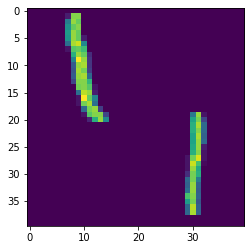

tensor([0])


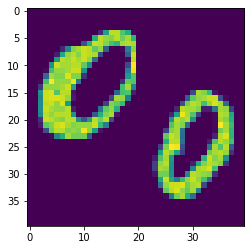

tensor([0])


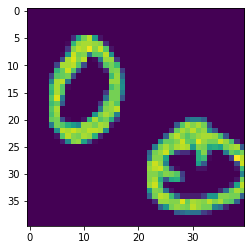

tensor([1])


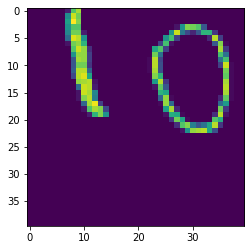

tensor([0])


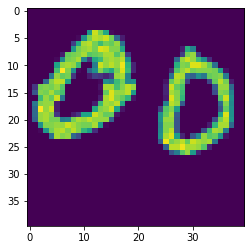

tensor([1])


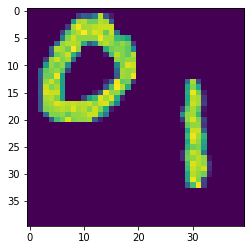

tensor([1])


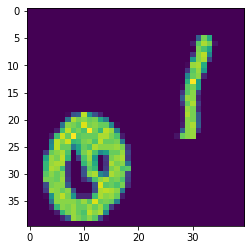

tensor([1])


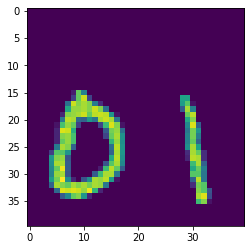

tensor([0])


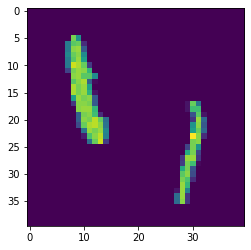

tensor([0])


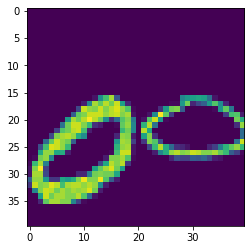

In [39]:
dataloader_iterator = iter(dataloader)
for i in range(10):
    datum = next(dataloader_iterator)
    print(datum['label'])
    plt.imshow(datum['encoded_image'].squeeze().sum(0))
    plt.show()
    # net.one_step(datum)
    # spikes = net.spikes["main1"].get("s").sum(0).squeeze().view(30,30)
    # print(torch.max(spikes))
    #plot_locally_connected_weights_meh2(net.connections[('input', 'main1')].w,spikes,100,1,0,20,12,3)
    plt.show()

# Feature Extraction 

In [32]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
if WANDB:
    wandb.init(project='BioLCNet', entity='singularbrain', config=network_hparams)
    
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection, wandb_active = WANDB)
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

AssertionError: ignored

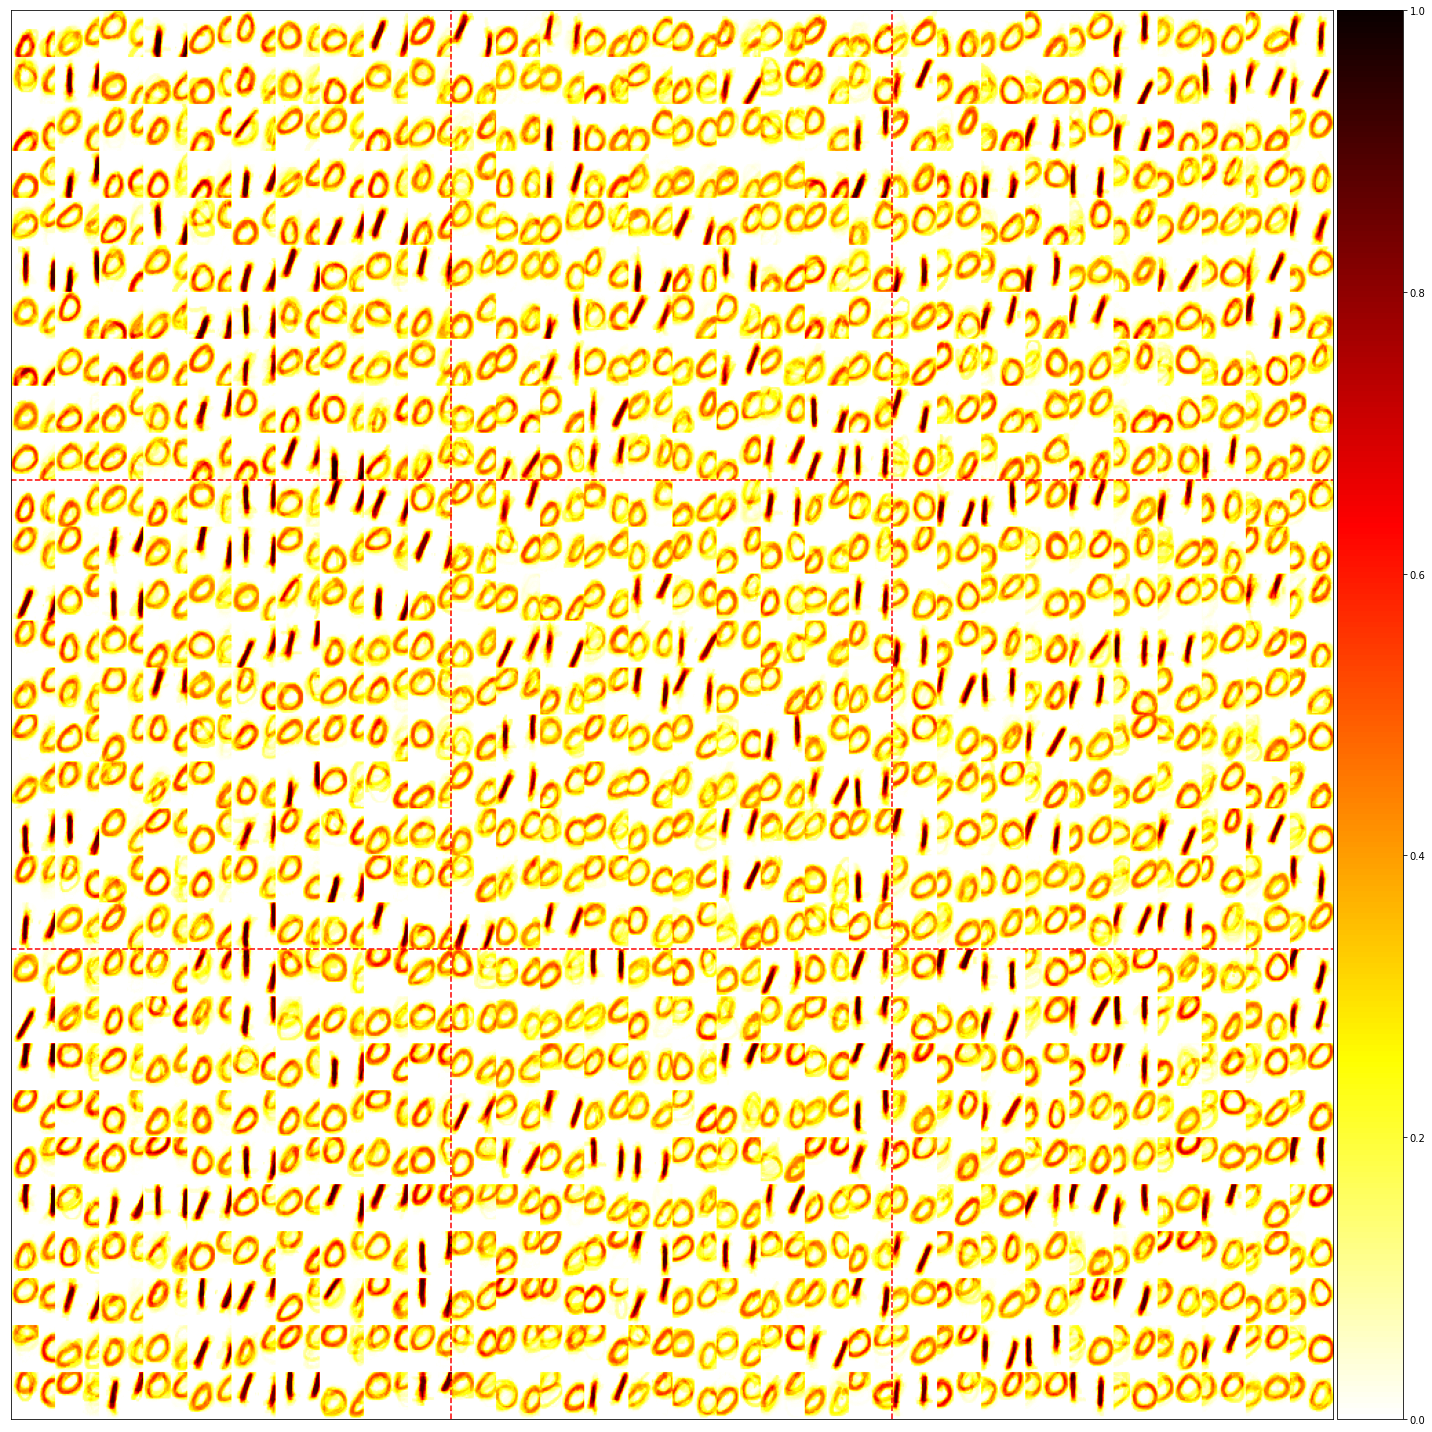

In [ ]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

plot_locally_connected_weights(
    weights= net.connections[("input","main1")].w,
    n_filters= hparams["n_channels1"],
    kernel_size= hparams["filter_size1"],
    conv_size= compute_size(hparams["crop_size"], hparams["filter_size1"], hparams["stride1"]),
    locations= net.connections[("input","main1")].locations,
    input_sqrt= hparams["crop_size"],
    wmin = 0.0,
    wmax = 1.0,
    figsize=(20, 20),
    cmap = "hot_r",)

In [ ]:
net.connections[('input', 'main1')]

LocalConnectionOrig(
  (source): Input()
  (target): AdaptiveLIFNodes()
)

In [ ]:
# plot_locally_connected_weights_meh(net.connections[('input','main1')].w,net.connections[(net.final_connection_source_name,'output')].w,\
#                                     0,5,net.neuron_per_class,net.n_channels1,net.in_channels,0,net.crop_size,net.filter_size1,net.layers['main1'].shape[1])

# Set up hyper-parameters

In [ ]:
train_hparams = {
    'n_train' : 60000,
    'n_test' : 9999,
    'n_val' : 1,
    'val_interval' : 250,
    'running_window_length': 500,
}

In [ ]:
# Dataset Hyperparameters
# target_classes = (0,1,2)
if target_classes:
    npz_file = np.load(f'DeepBioLCNet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    # npz_file = np.load('bindsnet/mask_0_1.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
    
else:
    mask = None
    mask_test = None
    n_classes = 10

data_hparams = { 
    'intensity': 1024*2,
    'crop_size': 20,
    'round_input': False,
}

In [ ]:
# for (i, datum) in enumerate(dataloader):
#     print(i, datum['encoded_image'].shape)

In [ ]:
n_neurons = 3 #100
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True
thresh_LC = -52
thresh_FC = -52
batch_size = 16
epochs = 1

network_hparams = {
    # net structure
    'crop_size': 20,
    'neuron_per_class': neuron_per_class,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 25,
    'n_channels2': 64,
    'filter_size1': 5,
    'filter_size2': 5,
    'stride1': 2,
    'stride2': 1,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    'single_output_layer': single_output_layer,
    'batch_size': batch_size,
    'epochs': epochs,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': True,
    'has_decision_period': True,
    'observation_period': 25,
    'decision_period': 25,
    'online': False,
    'local_rewarding': False,
     
    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'update_rule_LC': PostPre,
    'update_rule_LC2': None,
    'update_rule_Output': MSTDP,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0,1e-4),
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.1,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': True,
    'thresh_LC': thresh_LC,
    'thresh_FC': thresh_FC,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.02,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 100,
    'inh_LC': True,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,
    
    # Normalization
    'norm_factor_LC': 0.25*5*5,
    'norm_factor_LC2': None,
    'norm_factor_out': None,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamp
    'clamp_intensity': None,#1000,

    # Save
    'save_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25.pth',
    'LC_weights_path': None,#'/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f15_s4_inh100_norm25_ch100_inh25_weights.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,#'/content/drive/My Drive/LCNet/DeepLCNet_layer2_ch64_f5_s2_norm3.pth',

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': False,

}



reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    
    'variant': 'scalar',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 1.,
    'punishment_base': .2,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0005,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


network_hparams.update(
    {
     'time': 25+25+25, #320,
     'time_analysis': True,
    }
)
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test, batch_size=batch_size)

ValueError: ignored

In [ ]:
# dataloader_iterator = iter(dataloader)
# for i in range(10):
#     datum = next(dataloader_iterator)
#     plt.imshow(datum['encoded_image'].squeeze().sum(0))
#     plt.show()
#     net.one_step(datum)
#     spikes = net.spikes["main1"].get("s").sum(0).squeeze().view(30,30)
#     print(torch.max(spikes))
#     plot_locally_connected_weights_meh2(net.connections[('input', 'main1')].w,spikes,100,1,0,20,12,3)
#     plt.show()

# Training

In [ ]:
# from google.colab import drive
# if network_hparams['save_path'] or network_hparams['LC_weights_path']:    
#     drive.mount('/content/drive')

### Hyperparameters 1 

In [ ]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}

if WANDB:
    wandb.init(project='BioLCNet', entity='singularbrain', config=network_hparams)
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection, wandb_active = WANDB)
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

Reward,▂▅▂▅▁▇▅▆▁▆▂▁█▆▅▅▁█▁▃▆▂▁▃▆▅▁▅▂▃▂▅▃▃▅▅▃▂▇▇
input spikes,▄▂▃▂▃▁▃▂▃▂▂▅▁▄▂▃▄▄▃▃▄▃▂▄▅▃▁▃▂▃▂▃▃▂▃▃▃▂▂█
input to main1 convergence,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
input to main1 std,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
main1 spikes,█▆▅▄▃▃▄▃▃▂▃▃▃▃▂▃▃▃▃▂▃▂▂▃▃▂▁▁▁▁▁▂▁▂▁▁▁▁▁▄
main1 to output convergence,▂▂▁▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▃▁▂▂▃▄▃▂▃▅▅▅▆▆▇▇██▇▇▇▇
main1 to output std,██▄▆▅▇▇▆▆▆▆▄▇▄▇▅▆▆▆▅▄▄▇▄▁▁▃▇█▇▇▆▆▇█▆▇▅▅█
output spikes,█▆▆▅▅▄▅▄▄▃▃▄▃▄▃▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▃
training accuracy,█▅▅▆▆████▇▇▇███▇▇▆▆▆▆▅▄▄▃▃▃▃▂▂▁▁▁▁▂▂▂▂▂▂
Reward,160.0
input spikes,130697


True
tensor(0.5014) tensor(0.2898)
Previous model not found! Training from the beginning...



  0%|          | 0/60000 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
plot_locally_connected_weights(net.connections[('input', 'main1')].w, 25, 5, 8, net.connections[('input', 'main1')].locations, 25)

In [ ]:
plot_LC_weights(net.connections[('input', 'main1')])

In [ ]:
spikes_ = plot_LC_timepoint_spikes(net.sample_spikes['main1'][0], 40, 25, 1, 0, 8)

In [ ]:
print(spikes_)

In [ ]:
# sum(net.sample_spikes['main1'][0] == True)

In [ ]:
net.sample_spikes['main1'][0].shape

In [ ]:
net.spikes['main1'].get('s').shape

In [ ]:
net.connections[('input', 'main1')].w.shape

# Viz

In [ ]:
def plot_LC_timepoint_spikes(spikes: torch.Tensor,
    timepoint: int,
    n_filters: int,
    in_chans: int,
    slice_to_plot: int,
    conv_size: Union[int, Tuple[int, int]],
    im: Optional[AxesImage] = None,
    lines: bool = True,
    figsize: Tuple[int, int] = (10, 10),
    cmap: str = "hot_r",
    color: str='r'
    ):
    # language=rst
    """
    """

    n_sqrt = int(np.ceil(np.sqrt(n_filters)))
    sel_slice = spikes[timepoint].view(in_chans, n_filters, conv_size, conv_size).cpu()
    sel_slice = sel_slice[slice_to_plot, ...].view(n_filters, conv_size, conv_size)
    spikes_ = np.zeros((n_sqrt*conv_size, n_sqrt*conv_size))
    filt_counter = 0

    fig, ax = plt.subplots(figsize=figsize)

    for n1 in range(n_sqrt):
        for n2 in range(n_sqrt):
            filter_ = sel_slice[filt_counter, :, :].view(conv_size, conv_size)
            spikes_[n1 * conv_size : (n1 + 1) * conv_size, n2 * conv_size : (n2 + 1) * conv_size] = filter_
            filt_counter += 1
            ax.axhline((n1 + 1) * conv_size, color="g", linestyle="-")
            ax.axvline((n2 + 1) * conv_size, color="g", linestyle="--")
    ax.imshow(spikes_, cmap='Greys')
    return spikes_
    
def plot_FC_response_map(lc: object,
    fc: object,
    ind_neuron_in_group: int,
    label: int,
    n_per_class: int,
    input_channel: int = 0,
    scale_factor: float = 1.0,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r'
    ) -> AxesImage:
    # language=rst
    """
    Plot a connection weight matrix of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param fc: FC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input
    :param scale_factor: determines intensity of activation map  
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """

    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))

    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    sel_slice = sel_slice[input_channel, ...]
    input_size = _pair(int(np.sqrt(lc.source.n)))
    reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)
	
    ind_neuron = label * n_per_class + ind_neuron_in_group
    w = fc.w[:,ind_neuron].view(reshaped.shape[0]//lc.kernel_size[0],reshaped.shape[1]//lc.kernel_size[1])
    w = w.clip(lc.wmin,lc.wmax).repeat_interleave(lc.kernel_size[0], dim=0).repeat_interleave(lc.kernel_size[1], dim=1).cpu()

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu()*w, cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines:
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            ax.axhline(i - 0.5, color=color, linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i - 0.5, color=color, linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im

def plot_LC_activation_map(lc : object,
    spikes: torch.tensor,
    input_channel: int = 0,
    scale_factor: float = 1.0,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r'
    ) -> AxesImage:
    # language=rst
    """
    Plot an activation map of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input 
    :param scale_factor: determines intensity of activation map 
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """
    spikes = spikes.sum(0).squeeze().view(lc.conv_size[0]*int(np.sqrt(lc.out_channels)),lc.conv_size[1]*int(np.sqrt(lc.out_channels)))
    x = scale_factor * spikes / torch.max(spikes)
    x = x.clip(lc.wmin,lc.wmax).repeat_interleave(lc.kernel_size[0], dim=0).repeat_interleave(lc.kernel_size[1], dim=1).cpu()
    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))

    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    sel_slice = sel_slice[input_channel, ...]
    input_size = _pair(int(np.sqrt(lc.source.n)))
    reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu()*x, cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines:
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            ax.axhline(i - 0.5, color=color, linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i - 0.5, color=color, linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im


def reshape_LC_weights(
    w: torch.Tensor,
    n_filters: int,
    kernel_size: Union[int, Tuple[int, int]],
    conv_size: Union[int, Tuple[int, int]],
    input_sqrt: Union[int, Tuple[int, int]],
) -> torch.Tensor:
    # language=rst
    """
    Get the weights from a locally connected layer and reshape them to be two-dimensional and square.
    :param w: Weights from a locally connected layer.
    :param n_filters: No. of neuron filters.
    :param kernel_size: Side length(s) of convolutional kernel.
    :param conv_size: Side length(s) of convolution population.
    :param input_sqrt: Sides length(s) of input neurons.
    :return: Locally connected weights reshaped as a collection of spatially ordered square grids.
    """
    k1, k2 = kernel_size
    c1, c2 = conv_size
    i1, i2 = input_sqrt
    c1sqrt, c2sqrt = int(math.ceil(math.sqrt(c1))), int(math.ceil(math.sqrt(c2)))
    fs = int(math.ceil(math.sqrt(n_filters)))

    w_ = torch.zeros((n_filters * k1, k2 * c1 * c2))

    for n1 in range(c1):
        for n2 in range(c2):
            for feature in range(n_filters):
                n = n1 * c2 + n2
                filter_ = w[feature, n1, n2, :, :
                ].view(k1, k2)
                w_[feature * k1 : (feature + 1) * k1, n * k2 : (n + 1) * k2] = filter_

    if c1 == 1 and c2 == 1:
        square = torch.zeros((i1 * fs, i2 * fs))

        for n in range(n_filters):
            square[
                (n // fs) * i1 : ((n // fs) + 1) * i2,
                (n % fs) * i2 : ((n % fs) + 1) * i2,
            ] = w_[n * i1 : (n + 1) * i2]

        return square
    else:
        square = torch.zeros((k1 * fs * c1, k2 * fs * c2))

        for n1 in range(c1):
            for n2 in range(c2):
                for f1 in range(fs):
                    for f2 in range(fs):
                        if f1 * fs + f2 < n_filters:
                            square[
                                k1 * (n1 * fs + f1) : k1 * (n1 * fs + f1 + 1),
                                k2 * (n2 * fs + f2) : k2 * (n2 * fs + f2 + 1),
                            ] = w_[
                                (f1 * fs + f2) * k1 : (f1 * fs + f2 + 1) * k1,
                                (n1 * c2 + n2) * k2 : (n1 * c2 + n2 + 1) * k2,
                            ]

        return square

def plot_semantic_pooling(lc : object,
    input_channel: int = 0,
    output_channel: int = None,
    lines: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    cmap: str = "hot_r",
    color: str='r',
    ) -> AxesImage:
    # language=rst
    """
    Plot a connection weight matrix of a :code:`Connection` with `locally connected
    structure <http://yann.lecun.com/exdb/publis/pdf/gregor-nips-11.pdf>_.
    :param lc: LC connection object of LCNet
    :param input_channel: indicates weights which connected to this channel of input 
    :param output_channel: indicates weights of specific channel in the output layer
    :param lines: Whether or not to draw horizontal and vertical lines separating input regions.
    :param figsize: Horizontal, vertical figure size in inches.
    :param cmap: Matplotlib colormap.
    :return: Used for re-drawing the weights plot.
    """

    n_sqrt = int(np.ceil(np.sqrt(lc.out_channels)))
    sel_slice = lc.w.view(lc.in_channels, lc.out_channels, lc.conv_size[0], lc.conv_size[1], lc.kernel_size[0], lc.kernel_size[1]).cpu()
    input_size = _pair(int(np.sqrt(lc.source.n)))
    
    if output_channel is None:
        sel_slice = sel_slice[input_channel, ...]
        reshaped = reshape_LC_weights(sel_slice, lc.out_channels, lc.kernel_size, lc.conv_size, input_size)
    else:
        sel_slice = sel_slice[input_channel, output_channel, ...]
        sel_slice = sel_slice.unsqueeze(0)
        reshaped = reshape_LC_weights(sel_slice, 1, lc.kernel_size, lc.conv_size, input_size)
        print(reshaped.shape)

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(reshaped.cpu(), cmap=cmap, vmin=lc.wmin, vmax=lc.wmax)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.05)

    if lines and  output_channel is None:
        for i in range(
            n_sqrt * lc.kernel_size[0],
            n_sqrt * lc.conv_size[0] * lc.kernel_size[0],
            n_sqrt * lc.kernel_size[0],
        ):
            ax.axhline(i - 0.5, color=color, linestyle="--")

        for i in range(
            n_sqrt * lc.kernel_size[1],
            n_sqrt * lc.conv_size[1] * lc.kernel_size[1],
            n_sqrt * lc.kernel_size[1],
        ):
            ax.axvline(i - 0.5, color=color, linestyle="--")

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect("auto")

    plt.colorbar(im, cax=cax)
    fig.tight_layout()

    return im

In [ ]:
plot_locally_connected_weights_meh3(net.connections[('input','main1')].w,net.connections[(net.final_connection_source_name,'output')].w,\
                                    0,5,net.neuron_per_class,net.n_channels1,net.in_channels,0,net.crop_size,net.filter_size1,net.layers['main1'].shape[1]) 

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/runs'

## Save/Load Sessions

Save tensorBoard Session 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -a /content/runs/. /content/drive/MyDrive/LCNet/logs/

Read Saved Sessions

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/LCNet/logs/

## Optuna

install and import optuna

In [ ]:
!pip install optuna
import optuna

Define objective function

In [ ]:
STUDY_NAME  = ''
DATA_PATH = ''
N_TRIALS = ''

def objective(trial):
    ### Suggest parameters: 
    num_layers = trial.suggest_int('Number of Layers', 1, 4)
    dropout_rate  = trial.suggest_float('Dropout', 0, .99)
    activation = trial.suggest_categorical('activation', ['relu', 'selu', 'sigmoid', 'elu'])
    lr = trial.suggest_float('Learning rate', 1e-6, 1)
    network_hparams.update({
        
    })
    ###Define your model
    manual_seed(SEED)
    hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
    net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
    va_acc = net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)
    ### Define objective value
    objective_value = min(va_acc)

    
    return objective_value


Run the study

In [ ]:
study = optuna.create_study(study_name = STUDY_NAME , storage=f"sqlite:////content/drive/MyDrive/LCNet/optuna/optuna_study.db", load_if_exists=True)
study.optimize(objective, n_trials=N_TRIALS )

In [ ]:
study.best_params

Visualization

In [ ]:
plot_parallel_coordinate(study, params=["Learning rate", "Number of Layers", "Dropout"])

## Izhikevich 2007 - Task 2 | Pavlovian Conditioning

In [ ]:
train_hparams = {
    'n_train' : 4000,
    'n_test' : 500,
    'n_val' : 50,
    'val_interval' : 250,
    'running_window_length': 250,
}

In [ ]:
# Dataset Hyperparameters
target_classes = (8,9)
if target_classes:
    #npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    npz_file = np.load('bindsnet/mask_5.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
    
else:
    mask = None
    mask_test = None
    n_classes = 10

data_hparams = { 
    'intensity': 128,
    'crop_size': 22,
    'round_input': False,
}

In [ ]:
n_neurons = 2 #100
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True

network_hparams = {
    # net structure
    'crop_size': 22,
    'neuron_per_class': neuron_per_class,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 25,
    'n_channels2': 64,
    'filter_size1': 13,
    'filter_size2': 5,
    'stride1': 3,
    'stride2': 1,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    'single_output_layer': single_output_layer,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': False,
    'has_decision_period': True,
    'observation_period': 0,
    'decision_period': 256,
    'online': False,
    'local_rewarding': False,
     
    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'update_rule_LC': None,
    'update_rule_LC2': None,
    'update_rule_Output': MSTDP,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0.00,0.0),
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.01,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': False,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.05,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 1,
    'inh_LC': True,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,
    
    # Normalization
    'norm_factor_LC': 0.25*13*13,
    'norm_factor_LC2': None,
    'norm_factor_out': None,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamp
    'clamp_intensity': None,#1000,

    # Save
    'save_path': None,#'/content/drive/My Drive/LCNet/LCNet_phase2_baseline2_gpu.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/LCNet_phase2_baseline2_gpu.pth',
    'LC_weights_path': '/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f13_s3_inh100_norm3.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,#'/content/drive/My Drive/LCNet/DeepLCNet_layer2_ch64_f5_s2_norm3.pth',

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': True,
    'lc_convergence_vis': False,
    'out_convergence_vis': True,

}



reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    
    'variant': 'scalar',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 2.5,
    'punishment_base': 2.5,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0001,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


In [ ]:
time = 356 #320
network_hparams.update(
    {
     'time': time,
    }
)
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

In [ ]:
from google.colab import drive
if network_hparams['save_path'] or network_hparams['LC_weights_path']:    
    drive.mount('/content/drive')

In [ ]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.fit(dataloader = dataloader, label = torch.tensor([1]),val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

In [ ]:
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, hparams = hparams, **train_hparams)

In [ ]:
for i in range(20):
  net.one_step()

## Plotting the feature maps

In [ ]:
n_filts = (int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1)
n_filts

In [ ]:


print(net.connections[('input', 'main')].w.shape)

in_chans = 2
n_chans = 100
k = 12

reshaped_w = net.connections[('input', 'main')].w.view(in_chans, n_chans, n_filts, n_filts, k, k)

print(reshaped_w.shape)

In [ ]:
chan_idx = 20 # 0 to N_channels 
fig, axs = plt.subplots(n_filts, n_filts)
for i in range(n_filts):
    for j in range(n_filts):
        axs[i][j].imshow(reshaped_w[0,chan_idx,i,j].view(k, k).cpu(), cmap='Greys')
        axs[i][j].axis('off')
plt.show()